몇시간 동안 (또는 며칠 동안) 딥러닝 모델을 학습 시킨 후 만족할만한 결과를 얻었다면, 실무에 바로 적용시키고 싶으실 겁니다. 이 때 떠오르는 의문 중 하나가 "딥러닝 모델을 사용하려면 매번 이렇게 몇시간 동안 학습시켜야 되는 거야?"입니다. 대답은 "아니오" 입니다. 딥러닝 모델을 학습시킨다는 의미는 딥러닝 모델이 가지고 있는 뉴런들의 가중치(weight)을 조정한다는 의미이고, 우리는 모델 구성과 가중치만 저장만 해놓으면, 필요할 때 저장한 모델 구성과 가중치를 불러와서 사용하면 됩니다. 간단한 딥러닝 모델의 구성 및 가중치를 저장 및 불러오는 방법에 대해서 알아보겠습니다.

1. 간단한 모델 살펴보기
1. 실무에서의 딥러닝 시스템
1. 학습된 모델 저장하기
1. 모델 아키텍처 보기
1. 학습된 모델 불러오기

---

### 간단한 모델 살펴보기

아래는 MNIST 데이터셋(손글씨)을 이용하여 숫자를 분류하는 문제를 간단한 다층퍼셉트론 모델의 소스코드입니다. 이 코드에는 모델 구성부터 학습, 평가, 사용까지 포함하고 있습니다. 이를 위해 데이터셋 구성을 모두 갖추어서 훈련셋, 검증셋, 시험셋을 준비했습니다. 또한 훈련셋으로 학습한 모델을 임의의 시험셋으로 예측을 해보겠습니다.

In [10]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터셋 전처리
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# 원핫인코딩 (one-hot encoding) 처리
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 훈련셋과 검증셋 분리
x_val = x_train[:42000] # 훈련셋의 30%를 검증셋으로 사용
x_train = x_train[42000:]
y_val = y_train[:42000] # 훈련셋의 30%를 검증셋으로 사용
y_train = y_train[42000:]

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=64, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# 5. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('')
print('loss_and_metrics : ' + str(loss_and_metrics))

# 6. 모델 사용하기
xhat_idx = np.random.choice(x_test.shape[0], 5)
xhat = x_test[xhat_idx]
yhat = model.predict_classes(xhat)

for i in range(5):
    print('True : ' + str(argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat[i]))

Train on 18000 samples, validate on 42000 samples
Epoch 1/5
18000/18000 [==============================] - 1s - loss: 1.1162 - acc: 0.7223 - val_loss: 0.6408 - val_acc: 0.8448
Epoch 2/5
18000/18000 [==============================] - 1s - loss: 0.5095 - acc: 0.8698 - val_loss: 0.4707 - val_acc: 0.8752
Epoch 3/5
18000/18000 [==============================] - 1s - loss: 0.4094 - acc: 0.8898 - val_loss: 0.4120 - val_acc: 0.8859
Epoch 4/5
18000/18000 [==============================] - 1s - loss: 0.3647 - acc: 0.8997 - val_loss: 0.3764 - val_acc: 0.8952
Epoch 5/5
 9760/10000 [============================>.] - ETA: 0s
loss_and_metrics : [0.33107854363918304, 0.90869999999999995]
5/5 [==============================] - 0s
True : 0, Predict : 0
True : 4, Predict : 4
True : 4, Predict : 1
True : 3, Predict : 3
True : 3, Predict : 3


이 코드에서 '5. 모델 평가하기'까지가 학습을 하기 위한 과정이고, '6. 모델 사용하기'이후 코드가 학습된 모델을 사용하는 부분입니다. 이 사이를 분리하여 별도의 모듈로 만들면 우리가 원하는 결과를 얻을 수 있습니다.

---

### 실무에서의 딥러닝 시스템

모듈을 분리하기 전에 실무에서의 딥러닝 시스템을 살펴보겠습니다. 도메인, 문제에 마다 다양한 구성이 있겠지만, 제가 생각하는 딥러닝 시스템 구성은 다음과 같습니다.

![data](http://tykimos.github.io/warehouse/2017-6-10-Model_Load_Save_1.png)

우리가 만들고자 하는 전체 시스템을 목표 시스템이라고 했을 때, 크게 '학습 segment'와 '판정 segment'로 나누어집니다. '학습 segment'는 학습을 위해, 학습 데이터를 얻기 위한 '학습용 센싱 element', 센싱 데이터에서 학습에 적합한 형태로 전처리를 수행하는 '데이터셋 생성 element', 그리고 데이터셋으로 딥러닝 모델을 학습시키는 '딥러닝 모델 학습 element'으로 나누어집니다. '판정 segment'는 실무 환경에서 수집되는 센서인 '판정용 센싱 element'과 학습된 딥러닝 모델을 이용해서 센싱 데이터를 판정하는 '딥러닝 모델 판정 element'으로 나누어집니다. 앞서 본 코드에는 `딥러닝 모델 학습 element`와 `딥러닝 모델 판정 element`가 모두 포함되어 있습니다. 이 두가지 element를 분리해보겠습니다. 

    딥러닝 시스템은 크게 학습 부분과 판정 부분으로 나누어진다.

---

### 학습된 모델 저장하기

모델은 크게 모델 아키텍처와 모델 가중치로 구성됩니다. 모델 아키텍처는 모델이 어떤 층으로 어떻게 쌓여있는 지에 대한 모델 구성이 정의되어 있고, 모델 가중치는 처음에는 임의의 값으로 초기화되어 있지만, 훈련셋으로 학습하면서 갱신됩니다. 학습된 모델을 저장한다는 말은 '모델 아키텍처'와 '모델 가중치'를 저장한다는 말입니다. 케라스에서는 save() 함수 하나로 '모델 아키텍처'와 '모델 가중치'를 'h5'파일 형식으로 모두 저장할 수 있습니다. 

In [ ]:
from keras.models import load_model

model.save('mnist_mlp_model.h5')

전체 소스코드는 다음과 같습니다.

In [11]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터셋 전처리
x_train = x_train.reshape(60000, 784).astype('float32') / 255.0
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0

# 원핫인코딩 (one-hot encoding) 처리
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 훈련셋과 검증셋 분리
x_val = x_train[:42000] # 훈련셋의 30%를 검증셋으로 사용
x_train = x_train[42000:]
y_val = y_train[:42000] # 훈련셋의 30%를 검증셋으로 사용
y_train = y_train[42000:]

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(units=64, input_dim=28*28, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

# 3. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 4. 모델 학습시키기
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))

# 5. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('')
print('loss_and_metrics : ' + str(loss_and_metrics))

# 6. 모델 저장하기
from keras.models import load_model
model.save('mnist_mlp_model.h5')

Train on 18000 samples, validate on 42000 samples
Epoch 1/5
18000/18000 [==============================] - 1s - loss: 1.1422 - acc: 0.7133 - val_loss: 0.6466 - val_acc: 0.8376
Epoch 2/5
18000/18000 [==============================] - 1s - loss: 0.5103 - acc: 0.8712 - val_loss: 0.4688 - val_acc: 0.8720
Epoch 3/5
18000/18000 [==============================] - 1s - loss: 0.4079 - acc: 0.8896 - val_loss: 0.4065 - val_acc: 0.8875
Epoch 4/5
18000/18000 [==============================] - 1s - loss: 0.3621 - acc: 0.9001 - val_loss: 0.3733 - val_acc: 0.8952
Epoch 5/5
 9472/10000 [===========================>..] - ETA: 0s
loss_and_metrics : [0.32272637211084365, 0.9093]


'mnist_mlp_model.h5'라는 파일이 작업 디렉토리에 생성되었는 지 확인해봅니다. 예제에서는 424KB로 생성되었습니다. 저장된 파일에는 다음의 정보가 담겨 있습니다.

- 나중에 모델을 재구성하기 위한 모델의 구성 정보
- 모델를 구성하는 각 뉴런들의 가중치
- 손실함수, 최적하기 등의 학습 설정
- 재학습을 할 수 있도록 마지막 학습 상태

---

### 모델 아키텍처 보기

model_to_dat() 함수를 통해 모델 아키텍처를 가시화 시킬 수 있습니다. model 객체를 생성한 뒤라면 언제든지 아래 코드를 호출하여 모델 아키텍처를 블록 형태로 볼 수 있습니다. 

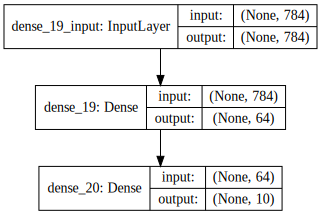

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

![svg](http://tykimos.github.io/warehouse/2017-6-10-Model_Load_Save_2.svg)

---

### 학습된 모델 불러오기

'mnist_mlp_model.h5'에는 모델 아키텍처와 학습된 모델 가중치가 저장되어 있으니, 이를 불러와서 사용해봅니다. 코드 흐름은 다음과 같습니다.
- 모델 불러오는 함수를 이용하여 앞서 저장한 모델 파일로부터 모델을 재형성합니다.
- 실제 데이터로 모델을 사용합니다. 이 때 주로 사용되는 함수가 predict() 함수이지만 Sequential 기반의 분류 모델을 사용할 경우 좀 더 편리하게 사용할 수 있도록 predict_classes() 함수를 제공합니다. 이 함수를 이용하면 가장 확률이 높은 클래스 인덱스를 알려줍니다.

In [13]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

# 1. 실무에 사용할 데이터 준비하기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_test = np_utils.to_categorical(y_test)
xhat_idx = np.random.choice(x_test.shape[0], 5)
xhat = x_test[xhat_idx]

# 2. 모델 불러오기
from keras.models import load_model
model = load_model('mnist_mlp_model.h5')

# 3. 모델 사용하기
yhat = model.predict_classes(xhat)

for i in range(5):
    print('True : ' + str(argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat[i]))

5/5 [==============================] - 0s
True : 8, Predict : 8
True : 7, Predict : 7
True : 1, Predict : 1
True : 0, Predict : 0
True : 4, Predict : 4


파일으로부터 모델 아키텍처와 모델 가중치를 재구성한 모델의 결과가 잘 나오는 것을 확인할 수 있습니다.

---

### Q & A

Q1) 모델 아키텍처와 모델 가중치를 따로 저장할 수는 없나요?

A1) 있습니다. 모델 아키텍처는 model.to_json() 함수와 model.to_yaml() 함수를 이용하면 json 혹은 yaml 형식의 파일로 저장할 수 있습니다. 가중치는 model.save_weights() 함수로 파일 경로를 인자로 입력하면 h5 형식의 가중치 파일이 생성됩니다. 따로 저장한 경우에는 구성 시에도 따로 해야 합니다. 모델 아키텍처를 먼저 구성한 뒤 가중치를 불러와서 모델에 셋팅하면 됩니다.

    from models import model_from_json
    json_string = model.to_json() # 모델 아키텍처를 json 형식으로 저장
    model = model_from_json(json_string) # json 파일에서 모델 아키텍처 재구성

    from models import model_from_yaml
    yaml_string = model.to_yaml() # 모델 아키텍처를 yaml 형식으로 저장
    model = model_from_yaml(yaml_string) # yaml 파일에서 모델 아키텍처 재구성
    
Q2) predict_classes() 함수는 Sequential 기반 모델에서만 사용가능한지요?

A2) 네, 맞습니다. functional API 기반 모델은 다수개의 입출력으로 구성된 다양한 모델을 구성할 수 있기 때문에 예측함수의 출력 형태 또한 다양합니다. 따라서 클랙스 인덱스를 알려주는 간단한 예측함수는 제공하지 않습니다.

---

### 요약

학습한 모델을 저장하고 불러오는 방법에 대해서 알아보았습니다. 저장된 파일에는 모델 구성 및 가중치 정보외에도 학습 설정 및 상태가 저장되므로 모델을 불러온 후 재 학습을 시킬 수 있습니다. 신규 데이터셋이 계속 발생하는 경우에는 재학습 및 평가가 빈번하게 일어날 수 있습니다. 또한 일반적인 딥러닝 시스템에서는 학습 처리 시간을 단축시키기 위해 GPU나 클러스터 장비에서 학습 과정이 이루어지나, 판정 과정은 학습된 모델 결과 파일을 이용하여 일반 PC 및 모바일, 임베디드 등에서 이루어집니다. 이처럼 도메인, 사용 목적 등에 따라 운영 시나리오 및 환경이 다양하기 때문에, 딥러닝 모델에 대한 연구도 중요하지만, 실무에 적용하기 위해서는 목표 시스템에 대한 설계도 중요합니다. 

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/lecture/)